In [1]:
# Install necessary libraries
!pip install torch matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Define the Transformer model
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_hidden_dim, num_layers, output_dim, max_seq_length):
        super(Transformer, self).__init__()

        # Embedding layer to convert input tokens to embeddings
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # Positional encoding to retain sequence information
        self.positional_encoding = nn.Parameter(self.get_positional_encoding(max_seq_length, embed_dim), requires_grad=False)

        # Transformer Encoder Layers
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim)
            for _ in range(num_layers)
        ])

        # Fully connected output layer
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        # Convert input indices to embeddings and add positional encoding
        x = self.embedding(x) + self.positional_encoding[:x.shape[1], :]

        # Pass through Transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x)

        # Pooling by taking the mean of the sequence
        x = x.mean(dim=1)

        # Fully connected output layer
        return self.fc_out(x)

    @staticmethod
    def get_positional_encoding(seq_length, d_model):
        """Generates positional encoding matrix"""
        position = torch.arange(seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)


In [3]:
# Parameters
input_dim = 1000  # Vocabulary size
embed_dim = 64  # Embedding dimensions
num_heads = 8  # Number of attention heads
ff_hidden_dim = 128  # Hidden layer size in feedforward network
num_layers = 3  # Number of encoder layers
output_dim = 10  # Number of output classes
max_seq_length = 50  # Maximum sequence length

In [4]:
# Instantiate model
model = Transformer(input_dim, embed_dim, num_heads, ff_hidden_dim, num_layers, output_dim, max_seq_length)
model

Transformer(
  (embedding): Embedding(1000, 64)
  (encoder_layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
# Example Usage
def example():
    """Runs an example input through the transformer."""
    sample_input = torch.randint(0, input_dim, (1, max_seq_length))  # Random input sequence
    output = model(sample_input)
    print("Output Shape:", output.shape)
    print("Output Values:", output)

example()

Output Shape: torch.Size([1, 10])
Output Values: tensor([[ 0.0140,  0.4945, -0.0355,  0.2385,  0.3825,  0.0610,  0.2520, -0.4035,
         -0.1495, -0.1096]], grad_fn=<AddmmBackward0>)


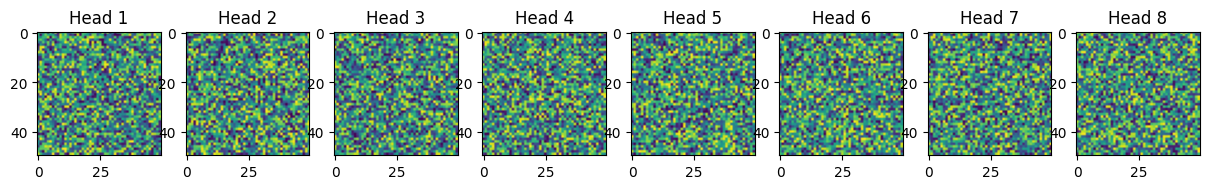

In [6]:
# Visualize attention weights for a dummy sequence
def plot_attention_map():
    """Plots a sample attention map."""
    dummy_attention_weights = torch.rand(num_heads, max_seq_length, max_seq_length)
    fig, axes = plt.subplots(1, num_heads, figsize=(15, 5))
    for i in range(num_heads):
        axes[i].imshow(dummy_attention_weights[i].detach().numpy(), cmap='viridis')
        axes[i].set_title(f'Head {i+1}')
    plt.show()

plot_attention_map()
